*** Author: Bailey Griswold ***  
*** PUI 2016, Professor Bianco, HW9 Assignment 1 ***  
*** November 7, 2016 ***  

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP (he will teach the Geopanda lecture).
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:

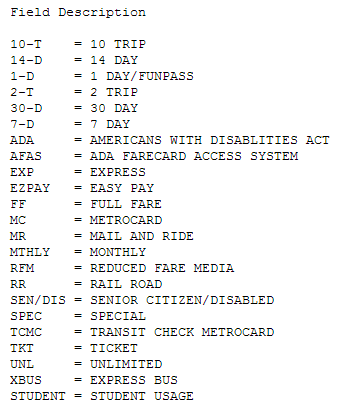

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the no.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```


as opposed to just 

use the no.nansum etc
```
np.mean(mtarides)
np.sum(mtarides)
```

In [2]:
from __future__ import print_function, division
#import os
import numpy as np
import pandas as pd
#import zipfile
#from getCitiBikeCSV import getCitiBikeCSV
import pylab as pl

#import geopandas as gp
#import sys
#import json
import os
import datetime
#import urllib
#import csv
#import requests

import statsmodels.api as sm
#import statsmodels.formula.api as smf

#from pandas.tools.plotting import scatter_matrix

puidata = os.getenv("PUIDATA")

%pylab inline
colors = ['y', 'm', 'c', 'r', 'g', 'b', 'w', 'k', 'DeepPink',\
          'DodgerBlue', 'Aquamarine', 'MediumSpringGreen',\
         'MidnightBlue', 'Gold', 'DarkSlateGray', 'LimeGreen', \
         'LightSeaGreen', 'Salmon', 'Indigo', 'DarkMagenta', \
         'Thistle', 'DeepSkyBlue', 'CadetBlue', \
         'BlueViolet', 'Chocolate', 'SaddleBrown', 'Maroon', \
         'Peru', 'DarkOrange', 'Teal', 'DarkKhaki']

Populating the interactive namespace from numpy and matplotlib


In [147]:
file = 'MTA_Fare.npy'
puidata = os.getenv("PUIDATA")
try:
    mtaRides = np.load(file)
    print ('its here')
    os.system("mv " + file + ' ' + puidata)
except:
    mtaRides = np.load(puidata + '/' + file)
    print ('its there')

mv MTA_Fare.npy /home/cusp/bg1672/PUIdata
its there


In [148]:
mtaRides.shape

(600, 23, 194)

In [4]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
weeks = {}
weeks[0] = datetime.date(2010, 5, 21)
week = datetime.timedelta(days=7)
for i in np.arange(1,195):
    weeks[i] = weeks[(i-1)] + week

In [5]:
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides < 0] = np.nan

In [6]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRides.shape)
mta_cards = np.nansum(mtaRides, axis=0)
print (mta_cards.shape)
#or for all ride types
mta_stations = np.nansum(mtaRides, axis=1)
print (mta_stations.shape)

(600, 23, 194)
(23, 194)
(600, 194)


## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

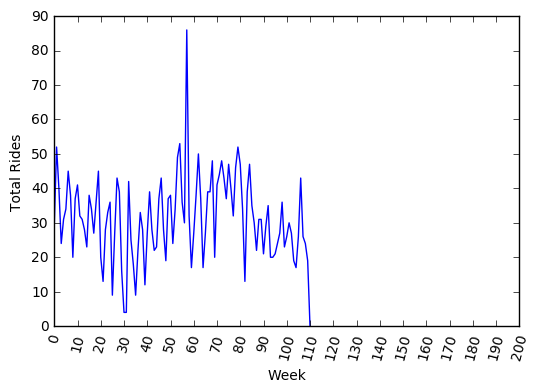

In [7]:
pl.plot(mtaRides[1,4])
pl.xticks(np.arange(0,201,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')

### Figure 1: Time Series for MTA station 2, for 30-Day Card Holders (5/21/10-2/21/14)
The sudden drop off at week 110 suggests that the station was closed.  A spike around week 55 indicates an event of unusually high ridership.  The up and down nature of the time series also indicates a pattern of sudden highs and dips that occur on somewhat consistent intervals.  

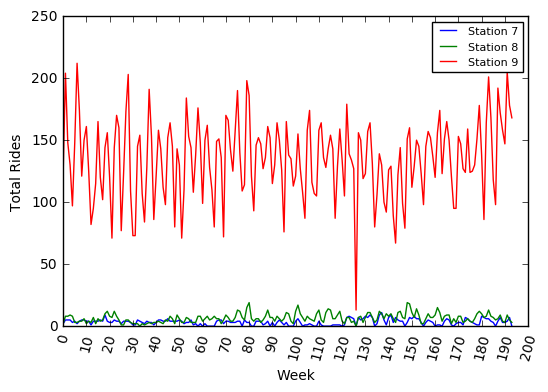

In [8]:
pl.plot(mtaRides[7,4], label='Station 7')
pl.plot(mtaRides[8,4], label='Station 8')
pl.plot(mtaRides[9,4], label='Station 9')
pl.xticks(np.arange(0,201,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')
pl.legend(fontsize=8)

### Figure 2: Time Series for MTA station 7, 8, and 9, for 30-Day Card Holders (5/21/10-2/21/14)
Stations 7 and 8 show significantly less ridership than station 9.  All three stations show periodicity in ridership.  There is a suggestion of an event around week 125, where ridership drops dramatically.

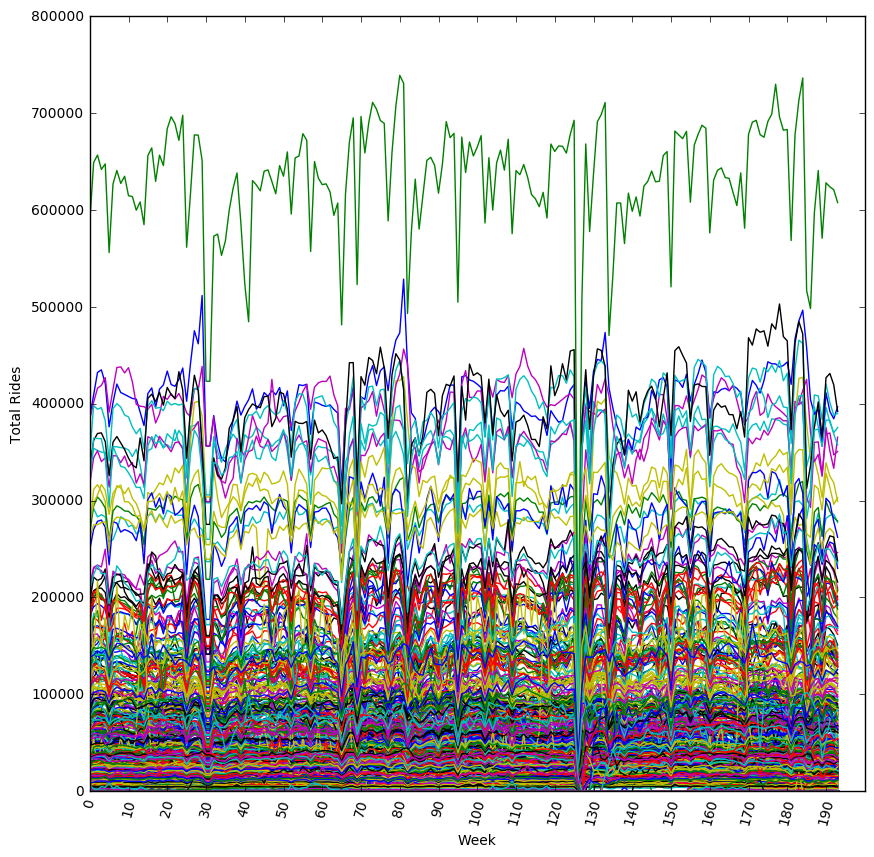

In [9]:
fig = pl.figure(figsize = (10, 10))
for i in arange(0,600):
    pl.plot(mta_stations[i], label=('Station {0}'.format(i)))
pl.xticks(np.arange(0,199,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')
#pl.legend(fontsize=5)

### Figure 3: Time Series for each MTA station for all Card Holder Types (5/21/10-2/21/14)
Although stations vary in mean ridership totals (some with means in the low thousands, and several with means over 300,000), each time series displays similar patterns of periodicity, and are affected very similarly by events (such as a spike around weeks 30 and 80, and a dramatic dip around week 130).  

*** Identify events that are more than 3 standard deviations away from the mean ***

In [10]:
print ("mean ridership (station {}) {:.2f}".format(21, np.nanmean(mta_stations[21])))
print ("stdev rides (station{}) {:.2f}".format(21, np.nanstd(mta_stations[21])))
thresholds = [np.nanmean(mta_stations[21]) + 3 * np.nanstd(mta_stations[21]), 
              np.nanmean(mta_stations[21]) - 3 * np.nanstd(mta_stations[21])]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean ridership (station 21) 404874.66
stdev rides (station21) 40139.54
3-sigma thresholds 525293.28 284456.04


3-sigma thresholds 525293.28 284456.04
Significant lower event: Week [126], 62317.0 Rides
Significant upper event: Week [81], 528556.0 Rides


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


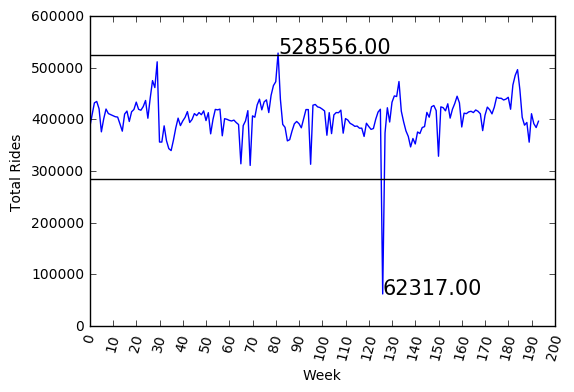

In [11]:
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))
print ('Significant lower event: Week {0}, {1} Rides'.format(np.where(mta_stations[21] == mta_stations[21].min())[0], \
                                                             mta_stations[21].min()))
print ('Significant upper event: Week {0}, {1} Rides'.format(np.where(mta_stations[21] == mta_stations[21].max())[0], \
                                                             mta_stations[21].max()))
pl.plot(mta_stations[21])
pl.plot([xlim()[0], xlim()[1]], [thresholds[1], thresholds[1]], color='k')
pl.plot([xlim()[0], xlim()[1]], [thresholds[0], thresholds[0]], color='k')
pl.xticks(np.arange(0,201,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')
pl.plot(np.where(mta_stations[21] == mta_stations[21].min())[0], mta_stations[21].min()) 
pl.plot(np.where(mta_stations[21] == mta_stations[21].max())[0], mta_stations[21].max())  
pl.text(np.where(mta_stations[21] == mta_stations[21].min())[0], mta_stations[21].min(),\
        "%.2f"%mta_stations[21].min(), fontsize=15)
pl.text(np.where(mta_stations[21] == mta_stations[21].max())[0], mta_stations[21].max(), \
        "%.2f"%mta_stations[21].max(), fontsize=15)
pl.legend(fontsize=5)

# Figure 4: Time Series for MTA station 21 for all Card Holder Types (5/21/10-2/21/14), plotted against thresholds.
The thresholds plotted on the graph indicate the upper and lower limits for data distribution.  The thresholds were calculated as the three standard deviations greater than and less than the mean. For station 21, the mean ridership and standard deviation is 404874.66 plus or minus 40139.54.  Based on these values, the 3-sigma thresholds 525293.28 284456.04.  Week 81 had a high number of rides that was a statistically significant event, with 528,556 rides happening on that day. An even more statistically significant event occurred on week 126, with 62, 317 rides occuring, which is signficantly lower than the mean number of rides occuring for this station.  

In [12]:
print ('Signficantly Low Number of rides: {0}, {1} rides'.format(weeks[126], mta_stations[21].min()))
print ('Signficantly High Number of rides: {0}, {1} rides'.format(weeks[81], mta_stations[21].max()))

Signficantly Low Number of rides: 2012-10-19, 62317.0 rides
Signficantly High Number of rides: 2011-12-09, 528556.0 rides


The event that occurred to cause such a low number of rides was Hurricane Sandy, which occured on October 22, 2012.  Many subway stations were shut down before the storm, and then many were out of use after the storm due to damage.  

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

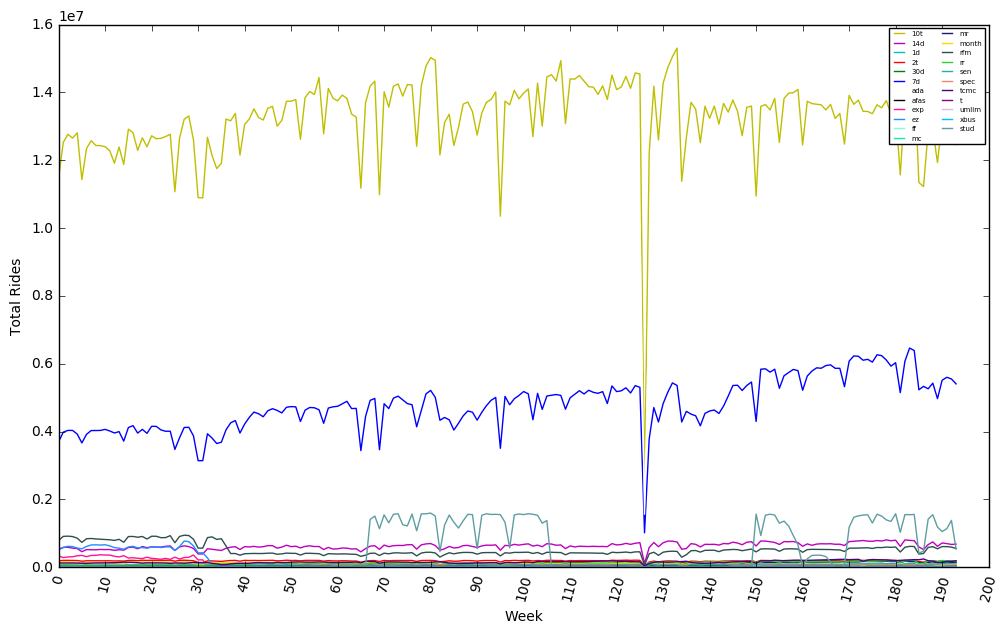

In [13]:
#Graph all 23 card types together as a time series
fig = pl.figure(figsize=(12,7))
for i in arange(0,(len(mta_cards))):
    pl.plot(mta_cards[i], color=(colors[i]), label=('{0}'.format(ridetype[i])))
pl.xticks(np.arange(0,201,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')
pl.legend(fontsize=5, loc='best', ncol=2)

### Figure 5: Time Series for each Card Holder Type, over all stations (5/21/10-2/21/14)
The graph showing the time series for each individual card type shows a similar downward event at week 126 which was observed in the timeseries for each station.  The card types show a range of means (with 10-trip card types having the highest mean around 1.2e7, and most having a much lower mean at .1e7 or below).  Additionally, trends and periodicity also appear to vary by card, as demonstrated by the different pattern shown by the sea green line (student) and the fushcia line (express).

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


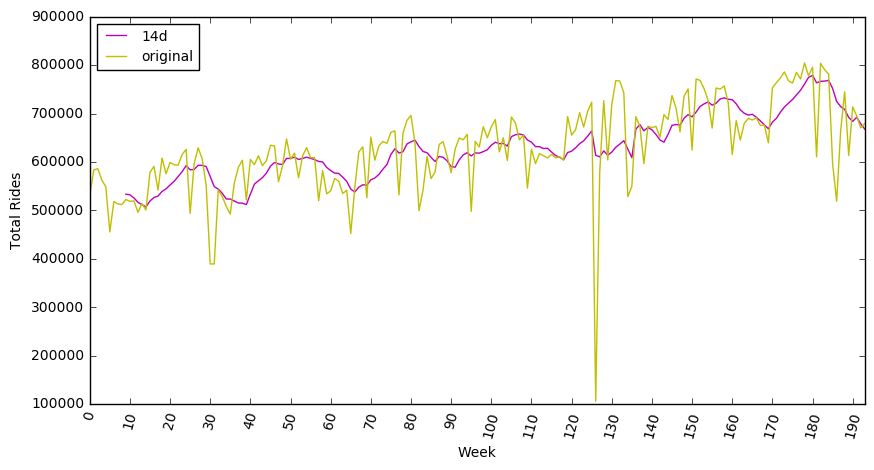

In [14]:
#Plot with rolling mean to visually assess rolling mean
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
#ax = pd.rolling_mean(mta_cards[1], 10).plot(fontsize=20)
pl.plot(pd.rolling_mean(mta_cards[1], 10), color=(colors[1]), label=('{0}'.format(ridetype[1])))
pl.xticks(np.arange(0,201,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')
ax.plot(mta_cards[1], label="original", color='y')
pl.legend(fontsize=10, loc='best')
#pl.figure()
#ax = pd.rolling_std(data['realgdp'], 10).plot(figsize=(15,15))
#ax.set_title("variance (rolling stdev,window 10 dp)", fontsize=30)
#pl.xlabel("quarters since 1959", fontsize=30)
#pl.ylabel("real GDP", fontsize=30)

#print ("gdp\n", 
#       data['realgdp'].dropna().head(), "\n", 
#       data['realgdp'].dropna().tail())

#print ("rolling mean of gdp\n", 
#       pd.rolling_mean(data['realgdp'], 10).dropna().head(), "\n", 
#       pd.rolling_mean(data['realgdp'], 10).dropna().tail())

### Figure 6: Non-stationary mean (rolling mean, window 10 dp) for 14 day cardholders, plotted against origional timeseries for all stations.  
Visually, there is a subtle upward trend, suggesting non-stationarity.  This station needs further analysis to confirm non-stationarity.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


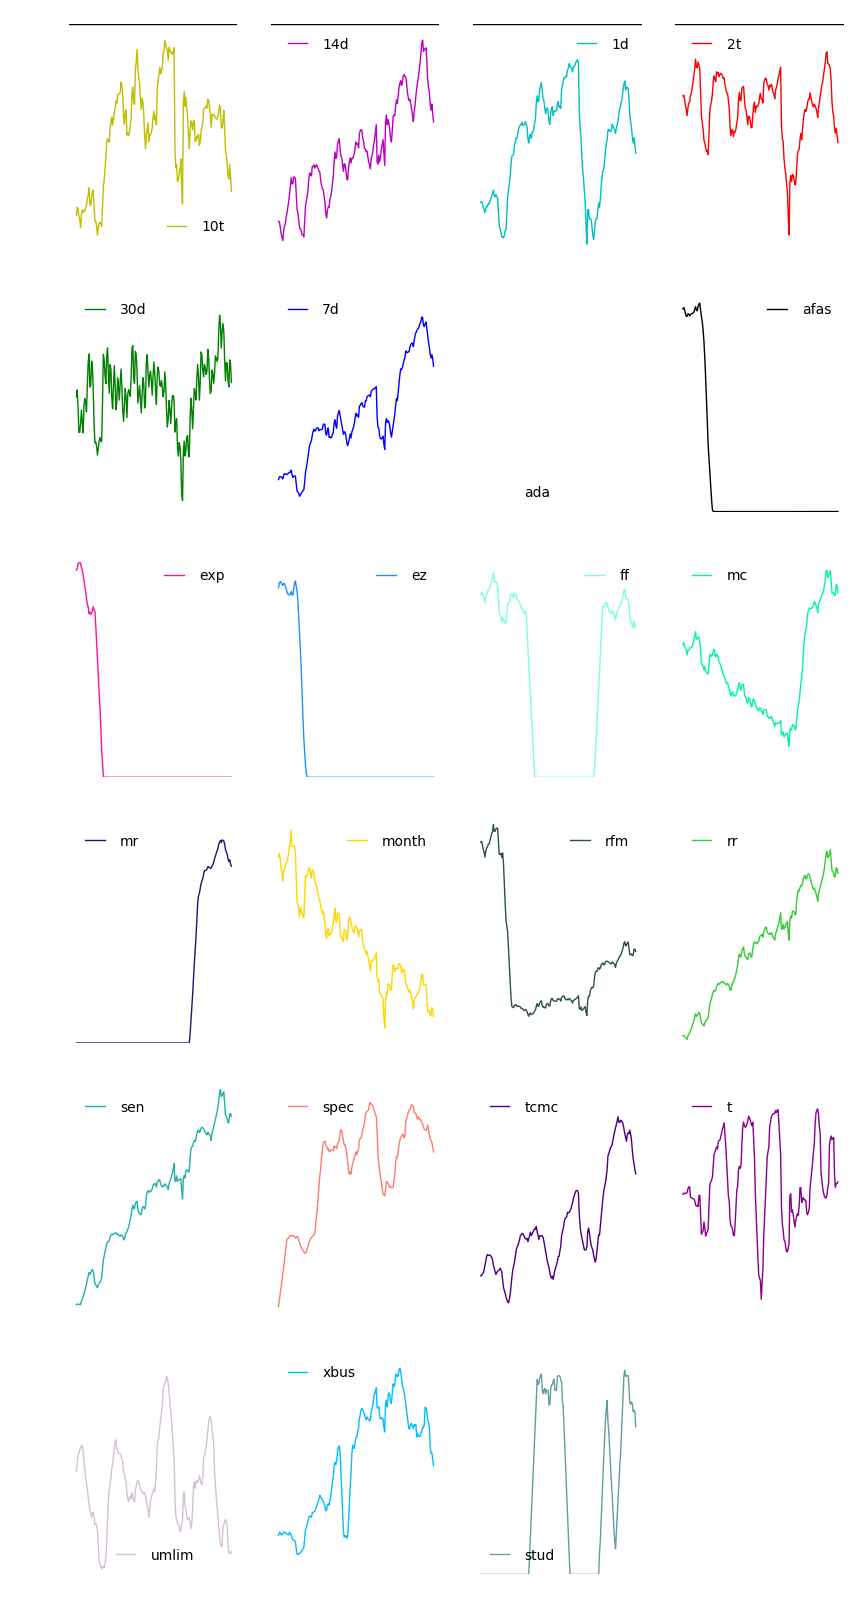

In [15]:
fig = pl.figure(figsize = (10, 20))
ax = []
for i in range(len(mta_cards)):
    ax.append(fig.add_subplot(6, 4, i+1)) #add subplots, last value tells you where to put it
    ax[i].plot(pd.rolling_mean(mta_cards[i], 10), color=(colors[i]), label=('{0}'.format(ridetype[i])))
    ax[i].axis('off')#remove the axes
    ax[i].legend(fontsize=10, loc='best', frameon=False)
    #ax[i].plot(data.max())#identify the max and the min of each series
    #ax[i].plot(data.min())
    #ax[i].plot(np.where(data == data.min())[0], data.min()) #plots a point at min point as a point
    #ax[i].plot(np.where(data == data.max())[0], data.max()) #could have more than 1 max, so choose 1st [0]
    #ax[i].text(0.95, 0.25, "%.2f"%data.min(), transform = ax[i].transAxes, fontsize=15)
    #ax[i].text(0.95, 0.5, "%.2f"%data.max(), transform = ax[i].transAxes, fontsize=15)
    #first arg in text tells you x and y location of text .95, .5
    # .95 plots it at x = .95...really you want it at 95% of x acis
    # always control the number of digits tha tyou plot by '.2%f' 
    if i<4:
        ax[i].plot((0,ax[i].get_xlim()[1]), (ax[i].get_ylim()[1], ax[i].get_ylim()[1]), 'k-',)
        #adds a straight line at the top

### Figure 7: Rolling Mean time series, 10 dp, for every MTA cardholder type (5/21/10-2/21/14)
The card types show distinctly different time series patterns.  Several are clearly non-stationary and show an overall upward trend, as demonstrated by the graphs of their rolling mean: 14-day unlimited (14d), 7-day unlimited (7d), rail road (rr), senior (sen), special (spec), transit check metrocard (tcmc), and express bus (xbus).  Monthly unlimited (month) shows a clear downward trend.  Others have more complex structure: student card rides show steep peaks and valleys, suggesting periods of high use, interpolated by relative inactivity.  This is explained by the school calendar, wiht students being given metrocards to use each semester, but very few if any are handed out over the summer.  Reduced fare media (rfm) also has a unique structure: it begins the time series with high ridership that swiftly falls off, but then slowly and steadily increases.  Express (exp) and Easypay (ez) have high ridership that falls suddenly to zero, suggesting that these card types were discontinued, whereas mail and ride (mr) shows the opposite trend: inactivity for a long period followed by a sudden uptick, indicating when that card type was introduced and made available for use. The graphs of 10-trip (10t), 2-trip (2t), 30-day (30d), ticket (tck) and unlimited (umlim) suggest stationary trends over the timeseries.     

*** Use AD Fuller Test to determine stationarity ***

Null Hypothesis: There is a unit root for the given mta ride type time series.
Alternate Hypothese: There is no unit root for the given mta ride type time series.

alpha = 0.05

In [16]:
#sm.tsa.adfuller?
'''The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, 
with the alternative that there is no unit root. If the pvalue is above a critical size, 
then we cannot reject that there is a unit root. 
No unit root generally means stationarity'''

'The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, \nwith the alternative that there is no unit root. If the pvalue is above a critical size, \nthen we cannot reject that there is a unit root. \nNo unit root generally means stationarity'

In [17]:
card_stash = {}
print ("Stationarity of each Ridership Type using AD Fuller test\n\n")
for i in range(len(mta_cards)): 
    if sm.tsa.adfuller(mta_cards[i])[0] > sm.tsa.adfuller(mta_cards[i])[4]['10%']:
        card_stash[ridetype[i]] = 'NONSTATIONARY'
        print ('Card Type {0} : NONSTATIONARY\n Fail to reject null that there is a unit root'.format(ridetype[i]))
    else:
        card_stash[ridetype[i]] = 'STATIONARY'
        print ('Card Type {0}: STATIONARY\n Reject Null that there is a unit root'.format(ridetype[i]))
    print ('  AD Fuller Statistic = {0}'.format(sm.tsa.adfuller(mta_cards[i])[0]))
    print ('  p-value = {0}\n'.format(sm.tsa.adfuller(mta_cards[i])[1]))
card_stash

Stationarity of each Ridership Type using AD Fuller test


Card Type 10t: STATIONARY
 Reject Null that there is a unit root
  AD Fuller Statistic = -11.325961874394512
  p-value = 1.1433626719252372e-20

Card Type 14d : NONSTATIONARY
 Fail to reject null that there is a unit root
  AD Fuller Statistic = -2.155191796667427
  p-value = 0.2229080909836994

Card Type 1d : NONSTATIONARY
 Fail to reject null that there is a unit root
  AD Fuller Statistic = -2.1295645402217853
  p-value = 0.23279389090904606

Card Type 2t: STATIONARY
 Reject Null that there is a unit root
  AD Fuller Statistic = -9.921236162804894
  p-value = 2.987132142606603e-17

Card Type 30d: STATIONARY
 Reject Null that there is a unit root
  AD Fuller Statistic = -3.9381284488787034
  p-value = 0.0017714896955103206

Card Type 7d : NONSTATIONARY
 Fail to reject null that there is a unit root
  AD Fuller Statistic = -1.515413330830902
  p-value = 0.5258732735319307

Card Type ada: STATIONARY
 Reject Null that there is a

{'10t': 'STATIONARY',
 '14d': 'NONSTATIONARY',
 '1d': 'NONSTATIONARY',
 '2t': 'STATIONARY',
 '30d': 'STATIONARY',
 '7d': 'NONSTATIONARY',
 'ada': 'STATIONARY',
 'afas': 'STATIONARY',
 'exp': 'STATIONARY',
 'ez': 'NONSTATIONARY',
 'ff': 'NONSTATIONARY',
 'mc': 'NONSTATIONARY',
 'month': 'NONSTATIONARY',
 'mr': 'NONSTATIONARY',
 'rfm': 'NONSTATIONARY',
 'rr': 'NONSTATIONARY',
 'sen': 'NONSTATIONARY',
 'spec': 'STATIONARY',
 'stud': 'STATIONARY',
 't': 'STATIONARY',
 'tcmc': 'STATIONARY',
 'umlim': 'STATIONARY',
 'xbus': 'NONSTATIONARY'}

In [18]:
# Print a list of the nonstationary card types
print ('NONSTATIONARY')
stash = []
for i in range(len(card_stash)):
    if card_stash[ridetype[i]] == 'NONSTATIONARY':
        stash.append(ridetype[i])
        print (ridetype[i])

NONSTATIONARY
14d
1d
7d
ez
ff
mc
mr
month
rfm
rr
sen
xbus


In [19]:
for i in range(len(ridetype)):
    for j in range(len(stash)):
        if stash[j] == ridetype[i]:
            print ('Last 10 to First 10 Ratio, Card Type {0}: {1:.2f}'
                   .format(ridetype[i],(np.sum(mta_cards[i][183:-1]))/(np.sum(mta_cards[i][0:10]))))

Last 10 to First 10 Ratio, Card Type 14d: 1.27
Last 10 to First 10 Ratio, Card Type 1d: 1.13
Last 10 to First 10 Ratio, Card Type 7d: 1.42
Last 10 to First 10 Ratio, Card Type ez: 0.00
Last 10 to First 10 Ratio, Card Type ff: 0.84
Last 10 to First 10 Ratio, Card Type mc: 1.24
Last 10 to First 10 Ratio, Card Type mr: 25082.72
Last 10 to First 10 Ratio, Card Type month: 0.59
Last 10 to First 10 Ratio, Card Type rfm: 0.66
Last 10 to First 10 Ratio, Card Type rr: 2.64
Last 10 to First 10 Ratio, Card Type sen: 2.94
Last 10 to First 10 Ratio, Card Type xbus: 1.72


# Analysis
The card types that showed the greatest increase in usage over the 194 weeks were senior cards (sen, 294% increase), rail road (rr, 264% increase), express bus (xbus, 172% increase), and 7-day (7d, 142% increase).  Mail and Ride (mr) showed the most dramatic increase because it was newly introduced through the time period and had a starting usage of 0%.  Easy pay (ez) had a dramatic decrease, since it was discontinued during the data collection period. Decreased use was seen for full fare (ff, decreases by 16%), and reduced fare media (rfm, decreased by 44%), with monthly showing the greatest reduction (month, decreased by 41%).  It is likely that the discontinued use of some cards will contribute to the increased use of other cards, and as new card types are introduced, it will pull riders from other card types.  

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [20]:
N = len(mta_stations[21])
print ("There are n=%d datapoints in the series"%N)

print ("What is on the x-axis of the FFT?")
print ("The FT is calculated at: " + "xax = [0, 1, ...,     N/2-1,     (N)/2] / (d*n) " +
       "(xax = [0, 1, ...,     N/2-1,     (N-1)/2] / (d*n) of n is odd)",
       "in units of inverse frequency where n is the size of the input array and d " + 
       "is the Sample spacing: what is the distance between datapoints in input array " + 
       "in units of weeks the Sample spacing here is 1 (1 measurement per week)")
print ("To get the FREQUENCY on the x axis we take 1.0/xax")
print ("The first two frequency caculated are infinity (1.0/0) ",
       "and the frequency corresponding to the entire duration of the series = N*d,"
       " and should be removed because they are uninteresting\n",
       np.fft.rfftfreq(N, 1.0)[0], "or ", 1.0/np.fft.rfftfreq(N, 1.0)[0], "and\n",
       np.fft.rfftfreq(N, 1.0)[1], "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[1]), "weeks\n\n")


print (1.0/np.fft.rfftfreq(N, 1.0)[0:2])
print (1.0/np.fft.rfftfreq(N, 1.0)[-3:-1])

print ("The fastest frequency you can calculate is every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(N, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[-1]), "weeks")

There are n=194 datapoints in the series
What is on the x-axis of the FFT?
The FT is calculated at: xax = [0, 1, ...,     N/2-1,     (N)/2] / (d*n) (xax = [0, 1, ...,     N/2-1,     (N-1)/2] / (d*n) of n is odd) in units of inverse frequency where n is the size of the input array and d is the Sample spacing: what is the distance between datapoints in input array in units of weeks the Sample spacing here is 1 (1 measurement per week)
To get the FREQUENCY on the x axis we take 1.0/xax
The first two frequency caculated are infinity (1.0/0)  and the frequency corresponding to the entire duration of the series = N*d, and should be removed because they are uninteresting
 0.0 or  inf and
 0.00515463917526 or every 194.0 weeks


[  inf  194.]
[ 2.04210526  2.02083333]
The fastest frequency you can calculate is every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


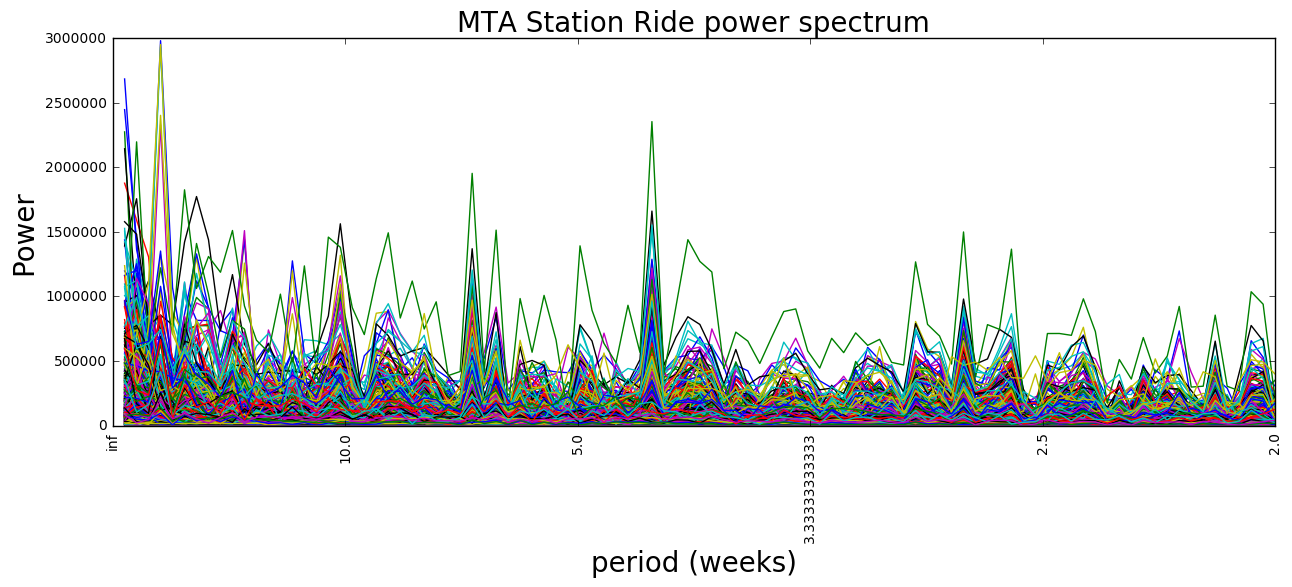

In [21]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in arange(0,(len(mta_stations))):
    f = np.abs(np.fft.rfft(mta_stations[i]))
    #ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')

    
  
allperiods = 1.0/np.fft.rfftfreq(N, 1.0)
#ax.set_xlim(0,1.0/15)
#ax.set_xticklabels([ "%s"%(f) for f in allperiods], rotation=90)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=90)
#ax.set_xticklabels([ "%s"%(1/4./f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (weeks)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("MTA Station Ride power spectrum", fontsize=20)

# Figure 8 Power Spectrum for all MTA Stations over sampling period from 5/21/10 to 2/21/14.  

In [22]:
#find where the period if 52 weeks
#The return of rfftrange() contains the frequencies. 
#You will not find exactly 52 weeks, because the array [0,1,...(n-1)/2)*n does not have the exact 52 value. 
#But there will be a frequency closest to 52.

#You can find what index that frequency corresponds to with where:
freqs = np.fft.rfftfreq(N, 1.0)
np.where(abs((1/freqs)-52) == min(abs((1/freqs)-52)))

(array([4]),)

In [23]:
power_yr = []
for i in range(len(mta_stations)):
    f = np.abs(np.fft.rfft(mta_stations[i]))
    power_yr.append(f[4])

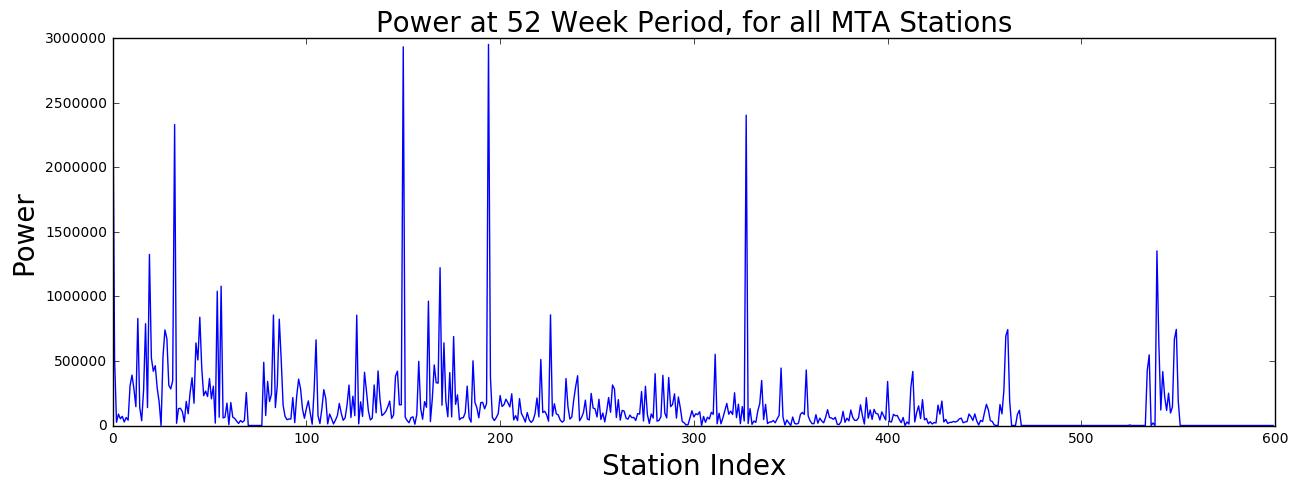

In [24]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

x = range(len(power_yr))
ax.plot(x, power_yr)

pl.xlabel("Station Index", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Power at 52 Week Period, for all MTA Stations", fontsize=20)

# Figure 9 Power at 52 Week Period for all MTA Stations
The x axis is the index of every MTA Station.  The y-values plotted against the indeces are the power value calculated at a frequency of once every 52 weeks, in other words, a year.  The plot shows fives stations with high power values at the 52 week period.  

In [25]:
print ('Indeces of MTA Stations with Trends that repeat on a yearly cycle')
yr_trend = []
for i in range(5):
    yr_trend.append(power_yr.index(max(power_yr)))
    print ('Station {}'.format(power_yr.index(max(power_yr))))
    power_yr.remove(max(power_yr))

Indeces of MTA Stations with Trends that repeat on a yearly cycle
Station 0
Station 193
Station 149
Station 324
Station 31


In [74]:
#pl.text(np.where(mta_stations[i][xcoords[j-j]:xcoords[j]] == mta_stations[i][xcoords[j-j]:xcoords[j]]\
        #                 .max())[0], mta_stations[i][xcoords[j-j]:xcoords[j]].max(), \
#for j in range(len(xcoords)):
#    yr_range = mta_stations[i][xcoords[j-1]:xcoords[j]]
#    print (np.where(mta_stations[i][xcoords[j-1]:xcoords[j]] == mta_stations[i][xcoords[j-1]:xcoords[j]]\
#                         .max())[0], mta_stations[i][xcoords[j-1]:xcoords[j]].max(), \
#        "%.2f"%mta_stations[i][xcoords[j-1]:xcoords[j]].max(), fontsize=15)
j = 0
print (mta_stations[193][xcoords[j]:xcoords[j+1]])

[ 72452.  83184.  80653.  80778.  82986.  70536.  82155.  82095.  79742.
  66419.  65733.  64652.  65529.  73064.  70236.  86375.  89051.  85891.
  85707.  86548.  91279.  87654.  89758.  90753.  73770.  69259.  79902.
  87451.  86444.  76293.  60049.  60036.  78588.  76950.  75238.  76176.
  82442.  71702.  80281.  71586.  71080.  83688.  84301.  80656.  84693.
  84991.  85686.  81889.  81993.  85367.  85647.  80420.]


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


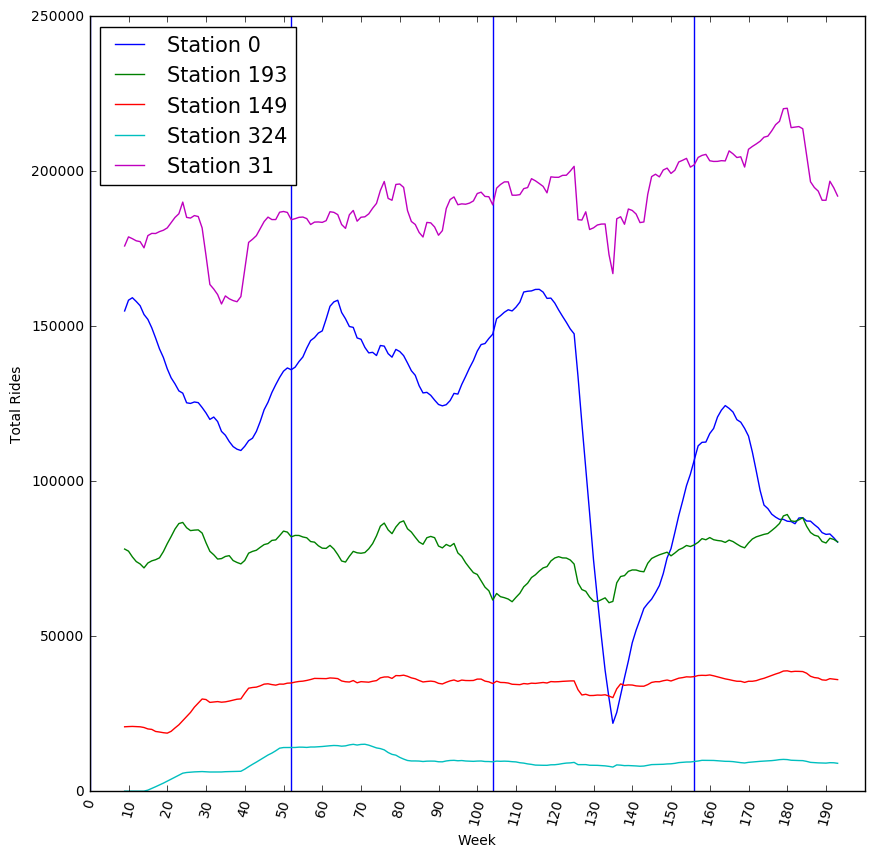

In [76]:
fig = pl.figure(figsize = (10, 10))
xcoords = [i * 52 for i in range(4)]
[pl.axvline(i) for i in xcoords]
for i in range(len(yr_trend)):
    pl.plot(pd.rolling_mean(mta_stations[(yr_trend[i])], 10), label=('Station {0}'.format(yr_trend[i])))

pl.xticks(np.arange(0,199,10), rotation=75, fontsize=10)
pl.xlabel('Week')
pl.ylabel('Total Rides')
pl.legend(fontsize=15, loc='best')

In [117]:
for i in range(len(yr_trend)):
    print ("Station {}".format(yr_trend[i]))
    peak = np.where(mta_stations[(yr_trend[i])][:52] == mta_stations[(yr_trend[i])][:52].max())
    print ("Max, Week {}".format(peak[0]))
    peak = np.where(mta_stations[(yr_trend[i])][:52] == mta_stations[(yr_trend[i])][:52].min())
    print ("Min, Week {}".format(peak[0]))

Station 0
Max, Week [8]
Min, Week [34]
Station 193
Max, Week [20]
Min, Week [31]
Station 149
Max, Week [51]
Min, Week [17]
Station 324
Max, Week [49]
Min, Week [ 0  1  4  6  7  9 10 13]
Station 31
Max, Week [21]
Min, Week [31]


In [118]:
print ('Week 8: {}'.format(weeks[8]))
print ('Week 20: {}'.format(weeks[20]))
print ('Week 51: {}'.format(weeks[51]))
print ('Week 49: {}'.format(weeks[49]))
print ('Week 21: {}'.format(weeks[21]))
print ('Week 34: {}'.format(weeks[51]))
print ('Week 31: {}'.format(weeks[49]))
print ('Week 17: {}'.format(weeks[21]))

Week 8: 2010-07-16
Week 20: 2010-10-08
Week 51: 2011-05-13
Week 49: 2011-04-29
Week 21: 2010-10-15
Week 34: 2011-05-13
Week 31: 2011-04-29
Week 17: 2010-10-15


# Analysis
The periods for MTA Stations 0, 193, 149, 324, and 31 show a periodicity of one year, with events repeating themselves on a yearly period.  The peaks travel for these stations occurs at the data listed above.  There are peaks around October, and dips around April/May.  







## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

# HINTS: 


## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, dependingon the question) the appropriate dimension in different parts of the homework: when you need to work on the station level, collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average). The sum and average functions take an "axis" argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the dight axis.


# Possibly useful functions

I  used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
```
np.fft.rfft(mydata) 
```  

    will return the *real* part of the fourier transform (which is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math. All you need to know is that you need the real part). But what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the 
```
np.array.flatten()
np.array.reshape()
```
    array methods allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````



In [27]:
#after reading the datacube you should see:
mtaRides.shape


(600, 23, 194)

ride types list

In [28]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [29]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [30]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRide.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtaRides, axis=1)
print (mta_allsum.shape)



NameError: name 'mtaRide' is not defined

## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [ ]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

In [ ]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 

...
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space